In [354]:
import numpy as np
import matplotlib.pyplot as plt

In [455]:
def weighted_average(values: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
    """ Get the centre of mass for a set of values, """
    assert weights is None or values.shape[0] == weights.shape[0]
    return np.average(values, weights=weights, axis=0)

def compute_transformation_params(x: np.ndarray, y: np.ndarray, p: np.ndarray = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform a single step of ICP where perfect corresponence is assumed. 
    Returns a rotation matrix and translation vector.
    """
    assert x.shape == y.shape
    if p is None:
        p = np.ones(len(x))
    # Get the centres of mass
    x_0 = weighted_average(x, p)
    y_0 = weighted_average(y, p)

    # Calculate cross covariance matrix
    H = (y_0 - y).T @ ((x_0 - x) * p[:, None])

    # Do SVD
    U, _S, Vh = np.linalg.svd(H)    

    # Calculate rotation matrix and translation vector
    R = Vh.T @ U.T
    t = y_0 - R @ x_0

    return R, t

[[-0.33333333  0.66666667  0.66666667]
 [ 0.66666667 -0.33333333  0.66666667]
 [ 0.66666667  0.66666667 -0.33333333]] [ 1.00000000e+00 -1.33226763e-15  0.00000000e+00]


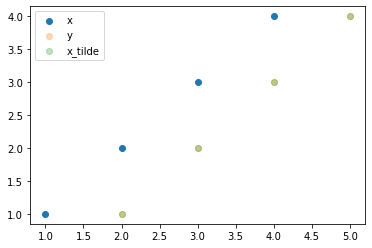

In [370]:
x = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
y = np.array([[2, 1, 1], [3, 2, 2], [4, 3, 3], [5, 4, 4]])

R, t = compute_transformation_params(x,y)
print(R,t)
x_tilde = (R @ x.T).T + t

plt.scatter(x[:, 0], x[:, 1], label='x')
plt.scatter(y[:, 0], y[:, 1], label ='y', alpha=0.3)
plt.scatter(x_tilde[:, 0], x_tilde[:, 1], label="x_tilde", alpha=0.3)
plt.legend()
plt.show()

In [ ]:
import numpy as np

def Exp(axis, angle):
    """
    Compute a rotation matrix from an axis-angle representation.

    Parameters:
        axis: A 3-element array representing the axis of rotation.
        angle: The angle of rotation in radians.

    Returns:
        A 3x3 rotation matrix representing the rotation.
    """
    # Normalize the axis vector
    axis = axis / np.linalg.norm(axis)

    # Compute the components of the rotation matrix
    c = np.cos(angle)
    s = np.sin(angle)
    t = 1 - c
    x, y, z = axis

    # Compute the rotation matrix
    R = np.array([[t*x*x + c,    t*x*y - s*z,  t*x*z + s*y],
                  [t*x*y + s*z,  t*y*y + c,    t*y*z - s*x],
                  [t*x*z - s*y,  t*y*z + s*x,  t*z*z + c]])

    return R

In [ ]:
def plain_point_to_point_icp(x: np.ndarray, y: np.ndarray, max_iterations: int = 100, tolerance: float = 1e-5) -> tuple[np.ndarray, np.ndarray]:
    # Initialize transformation parameters
    R = np.eye(3)  # Identity matrix
    t = np.zeros(3)  # Zero translation vector

    # Iterative loop
    for _ in range(max_iterations):
        # Correspondence: Find the closest point pairs
        distances = np.linalg.norm(y[:, None, :] - (R @ x.T)[:, :, None] - t[:, None], axis=0)
        closest_indices = np.argmin(distances, axis=1)

        # Weighting: Here, you might calculate weights based on distances
        
        # Estimation: Compute transformation parameters
        R_new, t_new = compute_transformation_params(x, y[closest_indices], weights=None)  # You can pass weights here

        # Transform: Apply the estimated transformation to the moving point cloud
        x_transformed = R_new @ x.T + t_new[:, None]

        # Convergence check
        if np.allclose(R, R_new) and np.allclose(t, t_new, atol=tolerance):
            break

        # Update transformation parameters
        R = R_new
        t = t_new

    return R, t


# Test polar2rectangular

In [384]:

angle_min = 0 # rad
angle_max = 2 * 3.14 # rad
angle_increment = angle_max / 360 # rad
ranges = np.arange(0,360)#np.random.randint(low = 0, high = 256, size = int((angle_max - angle_min) / angle_increment))
print(len(ranges))

360


In [385]:
angles = np.arange(angle_min, angle_max, step = angle_increment)

In [409]:
x = ranges * np.cos(angles)
y = ranges * np.sin(angles)
z = np.zeros(len(ranges))

# "rotate" by -90 degrees to get 0 degrees to be forwards
# replace x=-y with x=y to flip around x axis, i.e. scan direction clockwise
# can be seen in the header of the scan
temp = x
x = -y
y = temp

coords = np.vstack([x,y,z]).T
coords.shape

(360, 3)

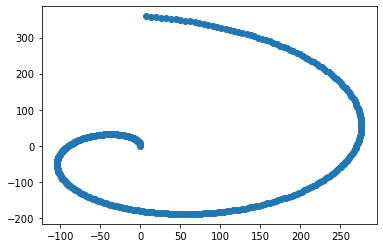

In [407]:
plt.scatter(coords[:,0], coords[:,1])
plt.show()

In [413]:

# Initialize transformation parameters
R = np.eye(3)  # Identity matrix
t = np.zeros(3)  # Zero translation vector

# Iterative loop
max_iterations = 1
tolerance = 1.0

for _ in range(max_iterations):
    # Correspondence: Find the closest point pairs
    distances = np.linalg.norm(y[:, None, :] - (R @ x.T)[:, :, None] - t[:, None], axis=0)
    closest_indices = np.argmin(distances, axis=1)

    # Weighting: Here, you might calculate weights based on distances
    
    # Estimation: Compute transformation parameters
    R_new, t_new = compute_transformation_params(x, y[closest_indices], weights=None)  # You can pass weights here

    # Transform: Apply the estimated transformation to the moving point cloud
    x_transformed = R_new @ x.T + t_new[:, None]

    # Convergence check
    if np.allclose(R, R_new) and np.allclose(t, t_new, atol=tolerance):
        break

    # Update transformation parameters
    R = R_new
    t = t_new



ValueError: operands could not be broadcast together with shapes (360,1,3) (3,360,1) 

In [414]:
from sklearn.neighbors import NearestNeighbors

In [434]:
x = coords
y = coords.copy()
y[:,0] += 30
y[:,1] += 10


In [493]:
y.shape

(360, 3)

In [514]:
a = np.random.randn(10,3)
a[:3,:2] = np.inf
a[np.all(a[:,] < np.inf,axis=1),:]

array([[ 0.09359745, -0.53916391, -1.4373956 ],
       [ 0.18793739, -0.45045446, -0.51687823],
       [-0.09563567,  0.3164238 ,  0.60333466],
       [-1.49459146, -0.11089408,  0.2412894 ],
       [-0.58264511, -0.24111265,  0.23636054],
       [ 0.12472073,  1.04632598, -0.27309186],
       [-0.53483402, -0.3065633 , -0.16224266]])

In [492]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(np.random.randn(360,0))

ValueError: Found array with 0 feature(s) (shape=(360, 0)) while a minimum of 1 is required by NearestNeighbors.

In [436]:

distance_threshold = 40
closest_point_pairs = []  # list of point correspondences for closest point rule

distances, indices = nbrs.kneighbors(x)
for nn_index in range(len(distances)):
    if distances[nn_index][0] < distance_threshold:
        closest_point_pairs.append((x[nn_index], y[indices[nn_index][0]]))


In [438]:
np.array(closest_point_pairs).shape

(360, 2, 3)

In [456]:
compute_transformation_params(np.array(closest_point_pairs)[:,0,:], np.array(closest_point_pairs)[:,1,:])

(array([[ 0.99993044, -0.01179495,  0.        ],
        [ 0.01179495,  0.99993044,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([15.309724  ,  5.66237311,  0.        ]))

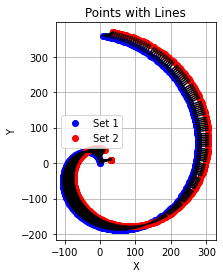

In [439]:
import matplotlib.pyplot as plt

def plot_points_with_lines(data):
    fig, ax = plt.subplots()
    
    # Plot points for the first set
    ax.plot(data[:, 0, 0], data[:, 0, 1], 'bo', label='Set 1')
    
    # Plot points for the second set
    ax.plot(data[:, 1, 0], data[:, 1, 1], 'ro', label='Set 2')
    
    # Plot lines between corresponding points
    for i in range(len(data)):
        ax.plot([data[i, 0, 0], data[i, 1, 0]], [data[i, 0, 1], data[i, 1, 1]], 'k-')
    
    ax.set_aspect('equal')
    ax.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Points with Lines')
    plt.grid(True)
    plt.show()

# Example data
import numpy as np
data = np.array(closest_point_pairs)

# Plotting
plot_points_with_lines(data)


In [451]:
from scipy.optimize import linear_sum_assignment

In [453]:
_, closest_indices = linear_sum_assignment(distances)


array([0])

In [459]:
(R @ x.T + t[:, None]).T.shape

(360, 3)